In [4]:
from helpers import load_CSD_data, make_element_wise_environments, filter_by_status
from rascal.utils import get_optimal_radial_basis_hypers
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from nice.blocks import *
from nice.utilities import *

In [5]:
import numpy as np

In [6]:
#------loading subsample of dataset--------

PATH_TRAIN = "./make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz"
PATH_TEST = "./make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz"
structures_test, shifts_test = load_CSD_data(PATH_TEST,prop_string="cs_iso")
structures_train, shifts_train = load_CSD_data(PATH_TRAIN,prop_string="cs_iso")#,random_subsample=200)
#does it work with masking?

#for structure in structures_train: mask_center_atoms_by_species(structure,species_select=[1])
#train_tensors = np.array([tensor for structure in structures_train for tensor in structure.arrays["CS"][structure.arrays["center_atoms_mask"]]])


In [5]:
structures_train = filter_by_status(structures_train,status="PASSING")

In [6]:
#define spherical_expansion hypers
hypers = dict(interaction_cutoff=4.5,
              max_radial=12,
              max_angular=9,
              gaussian_sigma_constant=0.3,
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=3.0,
                            exponent=6
                        ),
              radial_basis="GTO",
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False
              )

  0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: global_species is missing at least these species: '8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, '.

In [9]:
train_coefficients[1].shape

(76214, 32, 7, 13)

In [17]:
def get_nice():
    return StandardSequence([
        StandardBlock(ThresholdExpansioner(num_expand=150),
                      None,
                      IndividualLambdaPCAsBoth(n_components=50),
                      None,None,None),
        StandardBlock(ThresholdExpansioner(num_expand=150),
                      CovariantsPurifierBoth(max_take=10),
                      IndividualLambdaPCAsBoth(n_components=50),
                      ThresholdExpansioner(num_expand=300, mode='invariants'),
                      InvariantsPurifier(max_take=50),
                      InvariantsPCA(n_components=200)),
        StandardBlock(None, None, None,
                      ThresholdExpansioner(num_expand=300, mode='invariants'),
                      InvariantsPurifier(max_take=50),
                      InvariantsPCA(n_components=200))
    ],
                            initial_scaler=InitialScaler(
                                mode='signal integral', individually=True))

In [18]:
train_coefficients.keys()

dict_keys([1, 6, 7, 8])

In [19]:
nice = {1:get_nice()}

In [20]:
environments_for_fitting = 2500

In [21]:
nice[1].fit(train_coefficients[1][:environments_for_fitting])

In [24]:
train_features = transform_sequentially(nice, 
                                        structures_train, hypers, np.array([1]),block_size=250)

  0%|          | 0/8 [00:00<?, ?it/s]


RuntimeError: global_species is missing at least these species: '8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, '.

In [9]:
environments_for_fitting = 2500
transformers = get_transformer()
invariants = transformers.fit(coefficients[:environments_for_fitting])

/ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/nice/blocks/compressors.py:94: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 5000, while number of vectors is 2500, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 2500. Number of pca components is 500.
  warnings.warn(
/ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.08898e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/nice/blocks/compressors.py:94: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 5000, while number of vectors is 2500, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 2500. Number of pca components is 500.
  w

In [16]:

nice = {}
for key in train_coefficients.keys():
    nice[key] = get_nice()

for key in train_coefficients.keys():
    nice[key].fit(train_coefficients[key][:environments_for_fitting])

/ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/nice/blocks/compressors.py:94: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 5000, while number of vectors is 2500, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 2500. Number of pca components is 500.
  warnings.warn(
/ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.51909e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.16947e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-condition

KeyboardInterrupt: 

In [17]:
transformers

In [19]:
train_features = transform_sequentially({1:transformers for specie in all_species}, 
                                        structures_train, hypers, all_species)

  0%|          | 0/1 [00:00<?, ?it/s]/ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/nice/blocks/miscellaneous.py:137: RuntimeWarning: divide by zero encountered in true_divide
  result = 1.0 / np.sqrt(np.sum(coefficients[:, :, 0, 0]**2, axis=1))
/ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/nice/blocks/miscellaneous.py:166: RuntimeWarning: invalid value encountered in multiply
  return coefficients * multipliers
  0%|          | 0/1 [00:03<?, ?it/s]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [1]:
from rascal.representations import SphericalInvariants

"""hypers = {"soap_type": "PowerSpectrum",
          "interaction_cutoff": 3,
          "radial_basis": "GTO",
          "max_radial": 9,
          "max_angular": 9,
          "gaussian_sigma_constant": 0.3,
          "gaussian_sigma_type":"Constant",
          "cutoff_function_type":"ShiftedCosine",
          "cutoff_smooth_width": 0.5,
          "normalize": True,
          "compute_gradients":False,
          "cutoff_function_parameters":dict(rate=1,scale=3.5,exponent=4),
          #"optimization": dict(Spline=dict(accuracy=1.0e-05))
          #"expansion_by_species_method":'structure wise'
         }"""


hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4.5,
              max_radial=8,
              max_angular=5,
              gaussian_sigma_constant=0.3,
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=3.0,
                            exponent=6
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False
              )

In [5]:
hypers = get_optimal_radial_basis_hypers(hypers, structures_train, expanded_max_radial=20)

In [6]:
calculator = SphericalInvariants(**hypers)

In [7]:
shifts_train.shape

(340941,)

In [8]:
import numpy as np

In [9]:
def make_element_wise_environments_DEBUG(calculator,frames,y=None,select=False):
    """Returns shifts and environments of only one atomtype from the atoms in frames. 
       Or returns a dictionary of atomic-type-wise 
    
    Parameters
    ----------
    calculator : rascal.representations calculator object
                 calculator object with hyperparameters 
    
    frames     : list of ase.atoms objects
                 wrapped structures of the dataset
    
    y          : numpy array of shape (N_environments,X)
                 array of atomic properties
                 
    select     : int
                 atomic number to select atomic species
    Returns
    -------
    
    X_element_wise: dict or numpy.array
                    either dict with atomic numbers keys containing the representations in numpy array, 
                    or numpy array with representations of the selected atomic species
    y_element_wise: dict or numpy.array
                    either dict with atomic numbers keys containing the shifts in numpy arrays, 
                    or numpy array with representations of the selected atomic species
    
    """
    
    
    #get unique elements 
    y_element_wise = {}
    X_element_wise = {}
    
    atoms_list = calculator.transform(frames)
    X_repr = atoms_list.get_features(calculator)
    
    elements = np.unique(atoms_list.get_representation_info()[:,2])
    

    for element in elements:
        
        ind = atoms_list.get_representation_info()[:,2] == element
        print(ind.shape)
        if y is not None:
            y_element_wise[element] = y[ind]
        X_element_wise[element] = X_repr[ind]
    
    #TODO: Change this not to loop over array
    if select is not None:
        return X_element_wise[select], y_element_wise[select] 
    else:
        return X_element_wise, y_element_wise

In [10]:
H_environments_train, H_shifts_train = make_element_wise_environments_DEBUG(calculator,structures_train,shifts_train,select=1)

(37678,)
(37678,)
(37678,)
(37678,)


In [11]:
H_environments_train.shape

(15358, 14400)

In [12]:
from rascal.models.kernels import Kernel

In [13]:
print("%d megabytes" % (H_environments_train.size/1e06 * H_environments_train.itemsize))

1769 megabytes


In [14]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.kernel_approximation import Nystroem


import numpy as np

feature_map_nystroem = Nystroem(kernel='poly', degree=1, coef0=0,
                                random_state=1,
                                n_components=5000)
data_transformed = feature_map_nystroem.fit_transform(H_environments_train)

clf = KernelRidge(alpha=1e-06,kernel='poly', degree=1, coef0=0)
clf.fit(data_transformed, H_shifts_train)

KernelRidge(alpha=1e-06, coef0=0, degree=1, kernel='poly')

In [15]:
from sklearn.linear_model import Ridge

In [16]:
clf_r = Ridge(alpha=1e-06)
clf_r.fit(data_transformed, H_shifts_train)

Ridge(alpha=1e-06)

In [18]:
#eval
structures_test, shifts_test = load_CSD_data(PATH_TEST,prop_string="CS")
H_environments_test, H_shifts_test = make_element_wise_environments(calculator,structures_test,shifts_test,select=1)

In [19]:
this = feature_map_nystroem.transform(H_environments_test)

In [ ]:
this.shape

In [20]:
y_pred_r = clf_r.predict(this)

In [21]:
type(data_transformed)

numpy.ndarray

In [22]:
y_predicted

NameError: name 'y_predicted' is not defined

In [23]:
y_predicted = clf.predict(H_environments_test)

ValueError: X has 14400 features, but KernelRidge is expecting 5000 features as input.

In [14]:
len(H_shifts_test)

29913

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [25]:
np.sqrt(2*mean_squared_error(H_shifts_test[:,0], np.array(y_predicted),squared=True))

NameError: name 'y_predicted' is not defined

In [129]:
this.shape

(29913, 5000)

In [26]:
mean_squared_error(H_shifts_test[:,0], np.array(y_pred_r),squared=False)

0.688065700946885

In [27]:
mean_squared_error(H_shifts_test[:,0], np.array(y_predicted),squared=False)

NameError: name 'y_predicted' is not defined

In [57]:
mean_squared_error(H_shifts_test[:,0], np.array(y_predicted),squared=False)

0.8878319640343992

In [33]:
y_predicted

array([27.38763038, 27.38770087, 27.04081473, ..., 29.39186921,
       29.39274163, 29.39274741])

In [30]:
mean_absolute_error(H_shifts_test[:,0],y_pred_r)

0.5214721239692732

In [29]:
mean_absolute_error(H_shifts_test[:,0],y_predicted)

NameError: name 'y_predicted' is not defined

In [30]:
def optimize_hypers(X_train,X_test,y_train,y_test,y_ML_old,alphas=np.logspace(-8, 0, num=25)):
    errors = []
    errors_ml = []
    
    for val in alphas:
        clf = KernelRidge(alpha=val, degree=2)
        clf.fit(X_train, y_train)
        y_predicted = clf.predict(X_test)
        errors.append(np.sqrt(2*mean_squared_error(y_predicted, y_test,squared=True)))
        errors_ml.append(np.sqrt(2*mean_squared_error(y_ML_old, y_predicted,squared=True)))
    return errors, errors_ml, alphas
    
    
    

In [16]:
from sklearn.kernel_approximation import Nystroem

In [17]:
feature_map_nystroem = Nystroem(gamma=.2,
                                random_state=1,
                                n_components=10)

In [18]:
data = feature_map_nystroem.fit_transform(H_environments_test)


In [19]:
data.shape

(29913, 10)

In [20]:
data_transformed = feature_map_nystroem.fit_transform(H_environments_train)

In [60]:
from scipy.optimize import curve_fit

In [61]:
def from_msk_to_radial_scaling(weights,cutoffs):
    pass

In [62]:
def scaling_func(r,r0,m):
    return 1/(1+(r/r0)**m)

In [90]:
A = np.linspace(0,10,num=50)
g = np.vectorize(scaling_func)
B = g(A,3.0,6)

In [64]:
import matplotlib.pyplot as plt

In [80]:
kernel = np.array([256,128,32,8,8,1])
kernel = kernel/np.max(kernel)

In [82]:
distances = np.array([2,3,4,5,6,7])

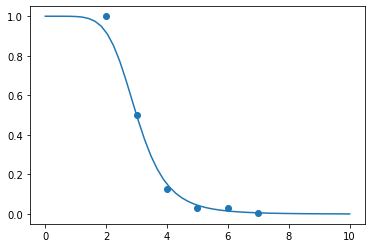

In [91]:
plt.plot(A,B)
plt.scatter(distances,kernel)